## **Data Mining Project - Deliverable 2**

Done by:

Student Name 1:  
Student ID 1: 20250422

Student Name 2: Bárbara Franco  
Student ID 2: 20250388

Student Name 3: Khadija Ennaifer 
Student ID 3: 20250439

This project's goal is to analyze customer loyalty membership data of AIAI and corresponding flight activity collected over a three-year period. This Deliverable will focus on the implementation of several clustering techniques. We will redo the treatment of the data and the merging done in the previous deliverable. Enconding, Scalling and Feature Selection will follow. Different clustering techniques will be explored for multiple perspectives, and a final clustering strategy will be chosen. Finally we will obtain a solution that supports the business' needs.

## **Table of Contents**

- [1. Importing Libraries, Loading and Reading Data](#1-loading-and-reading-data)

## **1. Importing Libraries, Loading and Reading Data**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from dateutil.relativedelta import relativedelta
from math import ceil

from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the and import the files
customerDB = pd.read_csv('DM_AIAI_CustomerDB.csv')
flightsDB = pd.read_csv('DM_AIAI_FlightsDB.csv')

## **2. Data Preparation**

### **2.1 Treatment of Duplicates and Missing Values**

This section has already been done in the previous deliverable, so we will only offer a short explanation of the procedures.

Drop the 20 observations that are duplicated in the column 'Unnamed: 0'. These were the last 20 observations of the dataset customersDB and they correspond exactly to the missing values in 'Income' and 'Customer Lifetime Value'. These clients entered and exited the program in the same day ( 'Cancellation Date' is the same as 'Enrollment Date Opening') and as expected they have no corresponding observations in the flights dataset. They won't bring valuable information so we will drop them from the customers dataset.

In [4]:
unnamed_duplicates = customerDB[customerDB.duplicated(subset='Unnamed: 0')]
customers_incorrect_index = unnamed_duplicates.index
customerDB.drop(customers_incorrect_index, inplace=True)

1.9% of the customers identification ('Loyalty#') are duplicated, but they represent different clients since the values on the other columns differ. These identifiers are also duplicated in the flights dataset. Since there wasn't a clear way to separate the customers, they represent a small part of the data, and we didn't want to introduce incorrect information to the data, we decided to drop these customers in both datasets.

In [5]:
duplicated_customers = customerDB[customerDB.duplicated(subset='Loyalty#', keep = False)]
customerDB.drop(duplicated_customers.index, inplace=True)
flightsDB.drop(flightsDB[flightsDB['Loyalty#'].isin(duplicated_customers['Loyalty#'])].index, inplace = True)

### **2.2 Rounding, Typecasting, and Datetime Conversion**

The columns 'NumFlightsWithCompanions' and 'NumFlights' are of the type float when logically they should be integers. They represent more than 15% of the flights' data so dropping them is not an option and there does not seem to exist an explanation for these errors, so we will simply round them and typecast them into integers.

In [6]:
flightsDB['NumFlights'] = flightsDB['NumFlights'].round().astype(int)

The columns 'YearMonthDate' from flightsDB and 'EnrollmentDateOpening' and 'CancellationDate' from customerDB will be converted to datetime since they represent dates.

In [7]:
flightsDB['YearMonthDate'] = pd.to_datetime(flightsDB['YearMonthDate'])
customerDB['EnrollmentDateOpening'] = pd.to_datetime(customerDB['EnrollmentDateOpening'], dayfirst = False)
customerDB['CancellationDate'] = pd.to_datetime(customerDB['CancellationDate'], format='mixed', errors='coerce')

### **2.3 Fixing Inconsistencies**

#### **2.3.1 Cancellation Date before Enrollment Date** 

In Deliverable 1, some quality issues were assessed, namely there were 199 customers who had a cancellation date prior to their enrollment date. The only explanations we found were that the dates had been switched or they could have been typed wrong. However since we dont want to lose any costumers info and have no other way to impute this value, we will believe the first assumption and switch the dates. We will create a copy of the a copy of the customers dataset and we will fix this and other inconsistencies in it. 

In [8]:
customers_cleaned = customerDB.copy()
cancel_before_enrol = customers_cleaned['CancellationDate'] < customers_cleaned['EnrollmentDateOpening']
customers_cleaned.loc[cancel_before_enrol, ['EnrollmentDateOpening', 'CancellationDate']] = \
    customers_cleaned.loc[cancel_before_enrol, ['CancellationDate', 'EnrollmentDateOpening']].values
# Selects the rows of the clients that have cancellation date before enrollment date and swap the two dates

##### **2.3.2 Months with zero flights but with distance**

Now for the flights data set, we found that there were 5823 observations that had 0 for the column 'NumFlights' but with values in 'DistanceKM' different from 0, which is not logical. 

In [9]:
no_flights_with_distance = flightsDB[(flightsDB['DistanceKM'] != 0) & (flightsDB['NumFlights'] == 0)]
no_flights_with_distance

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
19,261109,2021,12,2021-12-01,0,0.0,13736.0,1373.00,0.0,0.0
93,817609,2021,12,2021-12-01,0,0.0,23775.0,2377.00,0.0,0.0
96,192600,2021,12,2021-12-01,0,0.0,5119.0,511.00,0.0,0.0
116,883242,2021,12,2021-12-01,0,0.0,20681.0,2068.00,0.0,0.0
154,493800,2021,12,2021-12-01,0,0.0,17502.0,1750.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
607387,944702,2019,12,2019-12-01,0,0.0,29223.0,2922.30,0.0,0.0
607549,952629,2019,12,2019-12-01,0,0.0,27342.9,2734.29,0.0,0.0
607594,954973,2019,12,2019-12-01,0,0.0,6436.8,643.68,0.0,0.0
607744,962989,2019,12,2019-12-01,0,0.0,15922.8,1592.28,0.0,0.0


In [10]:
len(no_flights_with_distance) / len(flightsDB)

0.009759261493906117

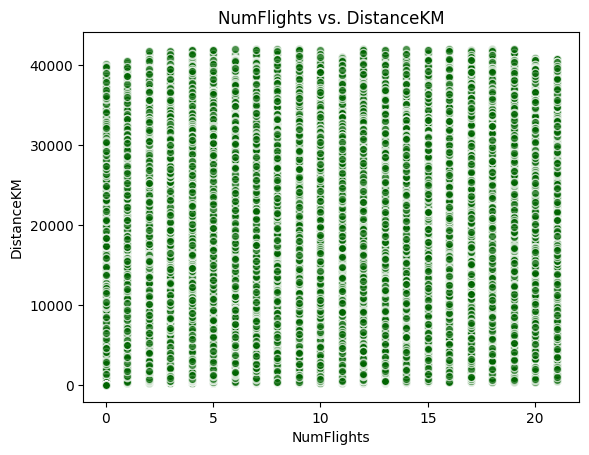

In [11]:
plt.scatter(flightsDB['NumFlights'], flightsDB['DistanceKM'], 
            color='darkgreen',  
            edgecolors='white',    
            alpha=0.7)            

plt.xlabel("NumFlights")
plt.ylabel("DistanceKM")

plt.title("NumFlights vs. DistanceKM") 
plt.show()

There is not a clear relationship between these features. It corresponds to less than 1% of the dataset and there is not a correct way to impute this values, so we will drop them. IS THIS THE CORRECT WAY ???

In [12]:
flights_cleaned = flightsDB.copy()
# flights_cleaned.drop(no_flights_with_distance.index, inplace=True)

### **2.4 Feature Engineering and Merging of the Datasets**

In order to segment the customers, it is crucial that we create new features and merge both datasets so that we can choose the most insightful features for the clustering algorithms.

#### **2.4.1 Feature in the flights dataset - Season**

We will create a new feature called 'Season' that assigns each observation to the season corresponding to its date. This variable could be really insightful to undersand and segment customers behavior (seasionality)

In [13]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

flights_cleaned['Season'] = flights_cleaned['Month'].apply(get_season)
flights_cleaned.head()

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed,Season
0,413052,2021,12,2021-12-01,2,2.0,9384.0,938.0,0.0,0.0,Winter
1,464105,2021,12,2021-12-01,0,0.0,0.0,0.0,0.0,0.0,Winter
2,681785,2021,12,2021-12-01,10,3.0,14745.0,1474.0,0.0,0.0,Winter
3,185013,2021,12,2021-12-01,16,4.0,26311.0,2631.0,3213.0,32.0,Winter
4,216596,2021,12,2021-12-01,9,0.0,19275.0,1927.0,0.0,0.0,Winter


#### **2.4.2 Dates**

We will start merging the datasest so we will create a new dataset called customers_merged.

On the previous deliverable, we showed that there are customers with flight activity before the enrollment date. For this reason we will alter 'EnrollmentDateOpening' so that the date of the first flight will be their new enrollment date if their first flight happen before they enrolled. We will start by extracting from flights_cleaned the first date with flight activity for each customer and then merge it with the customers' information

In [14]:
customers_cleaned.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,female,Bachelor,Urban,70146.0,Married,Star,2019-02-15,NaT,3839.14,Standard
2,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,male,College,Rural,0.0,Divorced,Star,2019-03-09,NaT,3839.61,Standard
4,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,male,College,Urban,0.0,Single,Star,2017-07-14,2021-01-08,3839.75,Standard
6,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,male,College,Suburban,0.0,Single,Star,2016-02-17,NaT,3839.75,Standard
8,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,male,Bachelor,Suburban,97832.0,Married,Star,2017-10-25,NaT,3842.79,2021 Promotion


In [15]:
first_flight_date = flights_cleaned[flights_cleaned['NumFlights'] > 0].sort_values(by=['Loyalty#','YearMonthDate'], ascending=True).groupby("Loyalty#", as_index=False)[['Loyalty#','YearMonthDate']].first()
customers_merged = pd.merge(customers_cleaned, first_flight_date, on='Loyalty#', how='left')
customers_merged.rename(columns={'YearMonthDate': 'FirstFlightDate'}, inplace=True)
customers_merged['FirstFlightDate'] = pd.to_datetime(customers_merged['FirstFlightDate'], format='%Y-%m')
customers_merged.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,FirstFlightDate
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,Bachelor,Urban,70146.0,Married,Star,2019-02-15,NaT,3839.14,Standard,2019-02-01
1,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,College,Rural,0.0,Divorced,Star,2019-03-09,NaT,3839.61,Standard,2019-01-01
2,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,College,Urban,0.0,Single,Star,2017-07-14,2021-01-08,3839.75,Standard,2019-01-01
3,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,College,Suburban,0.0,Single,Star,2016-02-17,NaT,3839.75,Standard,2019-01-01
4,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,Bachelor,Suburban,97832.0,Married,Star,2017-10-25,NaT,3842.79,2021 Promotion,2019-02-01


In [16]:
customers_merged['FirstFlightDate'].isnull().sum()

np.int64(1473)

In [17]:
no_flights = customers_merged[customers_merged['FirstFlightDate'].isnull()]
no_flights.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,FirstFlightDate
30,31,201574,Trudy,Roscoe,Trudy Roscoe,Canada,Ontario,Ottawa,45.421532,-75.697189,...,Bachelor,Suburban,26605.0,Married,Star,2018-04-06,2018-12-06,3893.31,Standard,NaT
38,39,834891,Wendell,Besley,Wendell Besley,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,Bachelor,Rural,30821.0,Married,Star,2020-03-08,2020-04-18,3911.12,Standard,NaT
66,67,329382,Ngoc,Dubuisson,Ngoc Dubuisson,Canada,Quebec,Montreal,45.501690,-73.567253,...,College,Suburban,0.0,Single,Star,2015-08-27,NaT,3961.59,2021 Promotion,NaT
71,72,357549,Elisha,Furna,Elisha Furna,Canada,British Columbia,Whistler,50.116322,-122.957360,...,Bachelor,Rural,60817.0,Single,Star,2019-05-21,2021-09-21,3964.73,Standard,NaT
82,83,283314,Vi,Scialdone,Vi Scialdone,Canada,Ontario,Toronto,43.653225,-79.383186,...,Bachelor,Suburban,54964.0,Married,Star,2016-04-17,2018-02-03,3991.73,Standard,NaT


In [18]:
len(no_flights) / len(customers_merged) * 100

8.887414021962108

There are null values for this new column. This means that these customers havent travelled since they entered the program. They form more than 8 % of AIAI's customers, so we will not remove them. These entries also do not affect the problem we are trying to solve, which is customers that **travelled** before they enrolled. 

We will now transform the column 'EnrollmentDateOpening' so that it is the minimum between the customers's enrollment date and date of the first flight.

In [19]:
customers_merged['EnrollmentDateOpening'] = customers_merged[['EnrollmentDateOpening', 'FirstFlightDate']].min(axis=1)
customers_merged.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,FirstFlightDate
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,Bachelor,Urban,70146.0,Married,Star,2019-02-01,NaT,3839.14,Standard,2019-02-01
1,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,College,Rural,0.0,Divorced,Star,2019-01-01,NaT,3839.61,Standard,2019-01-01
2,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,College,Urban,0.0,Single,Star,2017-07-14,2021-01-08,3839.75,Standard,2019-01-01
3,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,College,Suburban,0.0,Single,Star,2016-02-17,NaT,3839.75,Standard,2019-01-01
4,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,Bachelor,Suburban,97832.0,Married,Star,2017-10-25,NaT,3842.79,2021 Promotion,2019-02-01


To properly analyse the customers' flight activity we will create a Start Date and and End Date for each customer. The Start Date will be the enrollment date if it happen in the 3 year span of the flights dataset, otherwise it will be the first date of that interval. The End Date will be the end of the 3 year interval if the Cancellation Date is null, otherwise it will be the Cancellation Date if it happens in the span of the flights dataset activity or the Start Date if it does not. This way we can count the number of months where the customers were enrolled in the program and calculate proportions per month. 

In [20]:
customers_merged['Analysis_Start_Date'] = customers_merged['EnrollmentDateOpening'].apply(lambda x: max(x, pd.Timestamp('2019-01-01')))
# Analysis_Start_Date is the later date between EnrollmentDateOpening and 2019-01-01

customers_merged['Analysis_End_Date'] = np.where(
    customers_merged['CancellationDate'].notna(),  # has caccellation date
    np.where(
        customers_merged['CancellationDate'] < customers_merged['Analysis_Start_Date'],
        customers_merged['Analysis_Start_Date'],  # If the cancelation date is before the Start_Date then use Start_Date
        customers_merged['CancellationDate']  # otherwise use the cancellation date
    ),
    pd.Timestamp('2021-12-01')  # if its NaT then use 2021-12-01
)
customers_merged['Analysis_End_Date'] = pd.to_datetime(customers_merged['Analysis_End_Date'])

# Months in the program in the interval of the flights data set
customers_merged['Months_In_Program'] = (
    (customers_merged['Analysis_End_Date'].dt.year - customers_merged['Analysis_Start_Date'].dt.year) * 12 +
    (customers_merged['Analysis_End_Date'].dt.month - customers_merged['Analysis_Start_Date'].dt.month)
)

end_date = pd.Timestamp('2021-12-01')
end_or_cancel = customers_merged['CancellationDate'].fillna(end_date) 
# we can not use Analysis_End_Date here because if the cancellation date is before the start date we want to use the cancellation date

# Months since enrollment to end or cancellation date
customers_merged['Months_Since_Enrollment'] = (
    (end_or_cancel.dt.year - customers_merged['EnrollmentDateOpening'].dt.year) * 12 +
    (end_or_cancel.dt.month - customers_merged['EnrollmentDateOpening'].dt.month)
)

# Analysis Start and End Dates were only auxiliary columns for calculations, so we can drop them now
customers_merged.drop(columns=['Analysis_Start_Date', 'Analysis_End_Date'], inplace=True)
customers_merged.head()



,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,FirstFlightDate,Months_In_Program,Months_Since_Enrollment
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,70146.0,Married,Star,2019-02-01,NaT,3839.14,Standard,2019-02-01,34,34
1,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,0.0,Divorced,Star,2019-01-01,NaT,3839.61,Standard,2019-01-01,35,35
2,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,0.0,Single,Star,2017-07-14,2021-01-08,3839.75,Standard,2019-01-01,24,42
3,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,0.0,Single,Star,2016-02-17,NaT,3839.75,Standard,2019-01-01,35,70
4,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,97832.0,Married,Star,2017-10-25,NaT,3842.79,2021 Promotion,2019-02-01,35,50


#### **2.4.3 Total Flights and Points, Racios and Mean Distance Per Flight**

Now we will group the flights information by the customer identifiers and do some operations to ceartain features in order to get good insights on customer behavior. We will sum the number of flight with or withou companions, points accumulated and points redeemed, all for each customer. We will also extract the maximum number of flight with or without company, in a single month.

In [21]:
info_to_merge = flightsDB.groupby('Loyalty#')[['NumFlights', 'NumFlightsWithCompanions', 'PointsAccumulated', 'PointsRedeemed']].sum()

info_to_merge['NumFlights_Max'] = flightsDB.groupby('Loyalty#')[['NumFlights']].max()
info_to_merge['NumFlightsWithCompanions_Max'] = flightsDB.groupby('Loyalty#')[['NumFlightsWithCompanions']].max()


info_to_merge = info_to_merge.rename(columns={
    'NumFlights': 'TotalFlights',
    'NumFlightsWithCompanions': 'TotalFlightsWithCompanions',
    'PointsAccumulated': 'TotalPoints',
    'PointsRedeemed': 'TotalPointsRedeemed'})

info_to_merge.head()

,TotalFlights,TotalFlightsWithCompanions,TotalPoints,TotalPointsRedeemed,NumFlights_Max,NumFlightsWithCompanions_Max
Loyalty#,,,,,,
100018,231,49.4,53014.30,20562.8,17,7.0
100102,248,58.2,33903.96,18760.6,15,8.0
100140,217,54.2,43192.58,4896.0,15,8.0
100214,112,19.7,36453.77,12908.6,13,7.0
100272,187,53.1,42953.25,10891.4,16,9.0


It will also be interesting to have the racio of flights with companions and the racio of points redemeed to see which costumers tend to fly with company and which have a habit of redeeming their points.

In [22]:
info_to_merge['Ratio_Flights_Companions'] = info_to_merge['TotalFlightsWithCompanions'] / info_to_merge['TotalFlights']

info_to_merge['Ratio_Points_Redeemed'] = info_to_merge['TotalPointsRedeemed'] / info_to_merge['TotalPoints']

info_to_merge.head()


,TotalFlights,TotalFlightsWithCompanions,TotalPoints,TotalPointsRedeemed,NumFlights_Max,NumFlightsWithCompanions_Max,Ratio_Flights_Companions,Ratio_Points_Redeemed
Loyalty#,,,,,,,,
100018,231,49.4,53014.30,20562.8,17,7.0,0.213853,0.387873
100102,248,58.2,33903.96,18760.6,15,8.0,0.234677,0.553345
100140,217,54.2,43192.58,4896.0,15,8.0,0.249770,0.113353
100214,112,19.7,36453.77,12908.6,13,7.0,0.175893,0.354109
100272,187,53.1,42953.25,10891.4,16,9.0,0.283957,0.253564


There are people who like to travel far away, and others who do not. We will extract this information by calculationg the mean distance per flight for each customer.

In [23]:
customers_with_flights = flightsDB[flightsDB['NumFlights'] != 0]

info_to_merge['MeanDistancePerFlight'] = customers_with_flights.groupby('Loyalty#')['DistanceKM'].sum() / customers_with_flights.groupby('Loyalty#')['NumFlights'].sum()

info_to_merge.head()

,TotalFlights,TotalFlightsWithCompanions,TotalPoints,TotalPointsRedeemed,NumFlights_Max,NumFlightsWithCompanions_Max,Ratio_Flights_Companions,Ratio_Points_Redeemed,MeanDistancePerFlight
Loyalty#,,,,,,,,,
100018,231,49.4,53014.30,20562.8,17,7.0,0.213853,0.387873,2295.367965
100102,248,58.2,33903.96,18760.6,15,8.0,0.234677,0.553345,1367.397581
100140,217,54.2,43192.58,4896.0,15,8.0,0.249770,0.113353,1990.925346
100214,112,19.7,36453.77,12908.6,13,7.0,0.175893,0.354109,3255.372321
100272,187,53.1,42953.25,10891.4,16,9.0,0.283957,0.253564,2297.489305


Finally, we can add all this information to the corresponding customer by merging it with the customers_merged dataset

In [24]:
customers_merged = pd.merge(customers_merged, info_to_merge, on = 'Loyalty#', how='left')
customers_merged[['MeanDistancePerFlight', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed']] = customers_merged[['MeanDistancePerFlight', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed']].fillna(0)

customers_merged.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Months_Since_Enrollment,TotalFlights,TotalFlightsWithCompanions,TotalPoints,TotalPointsRedeemed,NumFlights_Max,NumFlightsWithCompanions_Max,Ratio_Flights_Companions,Ratio_Points_Redeemed,MeanDistancePerFlight
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,34,191,56.1,50699.39,13517.9,15,6.0,0.293717,0.266628,2604.054450
1,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,35,279,32.2,42672.54,22457.8,16,5.0,0.115412,0.526282,1397.630466
2,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,42,120,39.9,23832.41,5479.6,12,9.0,0.332500,0.229922,1915.185833
3,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,70,196,58.5,38595.63,16331.5,15,7.0,0.298469,0.423144,1969.537245
4,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,50,171,62.9,36916.56,0.0,17,7.0,0.367836,0.000000,2143.935673


#### **2.4.4 Proportions**

It would not be a fair to compare the total number of flights between a customer who has only entered the program 2 months ago and one that has been in the program since the beggining of the 3 year interval. For this reason, we will create several features with proportion of feature X per month, considering only the number of months where they were in the program.

In [25]:
customers_merged['PropNrFlights'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['TotalFlights'] / customers_merged['Months_In_Program'])

customers_merged['PropNrFlightsWithCompanions'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0, 
    customers_merged['TotalFlightsWithCompanions'] / customers_merged['Months_In_Program'])

customers_merged['PropCLV'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['Customer Lifetime Value'] / customers_merged['Months_In_Program'])

customers_merged['PropPoints'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['TotalPoints'] / customers_merged['Months_In_Program'])

customers_merged['PropPointsRedem'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['TotalPointsRedeemed'] / customers_merged['Months_In_Program'])

customers_merged.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,NumFlights_Max,NumFlightsWithCompanions_Max,Ratio_Flights_Companions,Ratio_Points_Redeemed,MeanDistancePerFlight,PropNrFlights,PropNrFlightsWithCompanions,PropCLV,PropPoints,PropPointsRedem
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,15,6.0,0.293717,0.266628,2604.054450,5.617647,1.650000,112.915882,1491.158529,397.585294
1,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,16,5.0,0.115412,0.526282,1397.630466,7.971429,0.920000,109.703143,1219.215429,641.651429
2,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,12,9.0,0.332500,0.229922,1915.185833,5.000000,1.662500,159.989583,993.017083,228.316667
3,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,15,7.0,0.298469,0.423144,1969.537245,5.600000,1.671429,109.707143,1102.732286,466.614286
4,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,17,7.0,0.367836,0.000000,2143.935673,4.885714,1.797143,109.794000,1054.758857,0.000000


#### **2.4.5 Diversity and Most Frequent Season, Recency and Churn Status**

We already created a feature Season in flights_cleaned. Now we only need to associate it with each costumer. For that we will create 2 new features, one corresponding to the most frequent season and another one showing the amount of seasons each customer traveled in. 

In [26]:
Mode_Season = flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['Season'].agg(lambda x: x.mode()[0])
Diversity_Season = flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['Season'].nunique()
Diversity_Season.value_counts()

Season
4    12681
3     1134
2      789
1      497
Name: count, dtype: int64

Now we will merge them with the customers' information

In [27]:
customers_merged = pd.merge(customers_merged, Mode_Season, on='Loyalty#', how='outer')
customers_merged = pd.merge(customers_merged, Diversity_Season, on='Loyalty#', how='outer')
customers_merged.rename(columns={ 'Season_x': 'MostFrequentSeason', 'Season_y': 'DiversitySeason'}, inplace=True)
customers_merged['MostFrequentSeason'] = customers_merged['MostFrequentSeason'].fillna('NoFlights')
customers_merged['DiversitySeason'] = customers_merged['DiversitySeason'].fillna(0)

customers_merged.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Ratio_Flights_Companions,Ratio_Points_Redeemed,MeanDistancePerFlight,PropNrFlights,PropNrFlightsWithCompanions,PropCLV,PropPoints,PropPointsRedem,MostFrequentSeason,DiversitySeason
0,2323,100018,Mina,Smida,Mina Smida,Canada,Alberta,Edmonton,53.544388,-113.490930,...,0.213853,0.387873,2295.367965,6.600000,1.411429,226.262857,1514.694286,587.508571,Autumn,4.0
1,4516,100102,Rigoberto,Palacio,Rigoberto Palacio,Canada,Ontario,Toronto,43.653225,-79.383186,...,0.234677,0.553345,1367.397581,7.085714,1.662857,82.506857,968.684571,536.017143,Autumn,4.0
2,4394,100140,Nakesha,Klaass,Nakesha Klaass,Canada,British Columbia,Dawson Creek,55.759628,-120.237660,...,0.249770,0.113353,1990.925346,6.200000,1.548571,81.087714,1234.073714,139.885714,Spring,4.0
3,167,100214,Loren,Juenemann,Loren Juenemann,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,0.175893,0.354109,3255.372321,3.200000,0.562857,119.159143,1041.536286,368.817143,Autumn,4.0
4,14398,100272,Siobhan,Lander,Siobhan Lander,Canada,Ontario,Toronto,43.653225,-79.383186,...,0.283957,0.253564,2297.489305,5.342857,1.517143,189.201429,1227.235714,311.182857,Summer,4.0


We will create a feature named 'Recency' that corresponds the number of months since each customer last travelled

In [28]:
Recency = (2021 - flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['YearMonthDate'].max().dt.year) * 12 + (12 - flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['YearMonthDate'].max().dt.month) 
Recency

Loyalty#
100018     0
100102     0
100140     1
100214     0
100272     1
          ..
999891    23
999902     2
999940     0
999982     1
999986     1
Name: YearMonthDate, Length: 15101, dtype: int32

Now we will merge it with customers_merged

In [29]:
customers_merged = pd.merge(customers_merged, Recency, on='Loyalty#', how='outer')
customers_merged.rename(columns={'YearMonthDate': 'Recency_Months'}, inplace=True)
customers_merged['Recency_Months'] = customers_merged['Recency_Months'].fillna(-1)  

customers_merged

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Ratio_Points_Redeemed,MeanDistancePerFlight,PropNrFlights,PropNrFlightsWithCompanions,PropCLV,PropPoints,PropPointsRedem,MostFrequentSeason,DiversitySeason,Recency_Months
0,2323,100018,Mina,Smida,Mina Smida,Canada,Alberta,Edmonton,53.544388,-113.490930,...,0.387873,2295.367965,6.600000,1.411429,226.262857,1514.694286,587.508571,Autumn,4.0,0.0
1,4516,100102,Rigoberto,Palacio,Rigoberto Palacio,Canada,Ontario,Toronto,43.653225,-79.383186,...,0.553345,1367.397581,7.085714,1.662857,82.506857,968.684571,536.017143,Autumn,4.0,0.0
2,4394,100140,Nakesha,Klaass,Nakesha Klaass,Canada,British Columbia,Dawson Creek,55.759628,-120.237660,...,0.113353,1990.925346,6.200000,1.548571,81.087714,1234.073714,139.885714,Spring,4.0,1.0
3,167,100214,Loren,Juenemann,Loren Juenemann,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,0.354109,3255.372321,3.200000,0.562857,119.159143,1041.536286,368.817143,Autumn,4.0,0.0
4,14398,100272,Siobhan,Lander,Siobhan Lander,Canada,Ontario,Toronto,43.653225,-79.383186,...,0.253564,2297.489305,5.342857,1.517143,189.201429,1227.235714,311.182857,Summer,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,2020,999902,Rhoda,Brugliera,Rhoda Brugliera,Canada,Ontario,Toronto,43.653225,-79.383186,...,0.172142,2285.241573,7.628571,2.165714,208.287714,1743.044286,300.051429,Spring,4.0,2.0
16570,8275,999911,Corrinne,Lewison,Corrinne Lewison,Canada,Newfoundland,St. John's,47.561508,-52.712578,...,0.000000,0.000000,0.000000,0.000000,244.707714,0.000000,0.000000,NoFlights,0.0,-1.0
16571,9549,999940,Pura,Dejulio,Pura Dejulio,Canada,Quebec,Quebec City,46.813877,-71.207977,...,0.235584,2706.468235,3.148148,1.051852,750.611111,883.540370,208.148148,Autumn,4.0,0.0
16572,11473,999982,Gladis,Sweeton,Gladis Sweeton,Canada,British Columbia,Victoria,48.428421,-123.365650,...,0.000000,1874.090909,4.400000,0.400000,526.312000,1052.800000,0.000000,Autumn,2.0,1.0


Finally we will create a variable named 'ChurnStatus' that identifies wether the customer is in the program or not

In [30]:
customers_merged['ChurnStatus'] = customers_merged['CancellationDate'].apply(
    lambda x: 'Cancelled' if pd.notna(x) else 'Active'
)

customers_merged.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,MeanDistancePerFlight,PropNrFlights,PropNrFlightsWithCompanions,PropCLV,PropPoints,PropPointsRedem,MostFrequentSeason,DiversitySeason,Recency_Months,ChurnStatus
0,2323,100018,Mina,Smida,Mina Smida,Canada,Alberta,Edmonton,53.544388,-113.490930,...,2295.367965,6.600000,1.411429,226.262857,1514.694286,587.508571,Autumn,4.0,0.0,Active
1,4516,100102,Rigoberto,Palacio,Rigoberto Palacio,Canada,Ontario,Toronto,43.653225,-79.383186,...,1367.397581,7.085714,1.662857,82.506857,968.684571,536.017143,Autumn,4.0,0.0,Active
2,4394,100140,Nakesha,Klaass,Nakesha Klaass,Canada,British Columbia,Dawson Creek,55.759628,-120.237660,...,1990.925346,6.200000,1.548571,81.087714,1234.073714,139.885714,Spring,4.0,1.0,Active
3,167,100214,Loren,Juenemann,Loren Juenemann,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,3255.372321,3.200000,0.562857,119.159143,1041.536286,368.817143,Autumn,4.0,0.0,Active
4,14398,100272,Siobhan,Lander,Siobhan Lander,Canada,Ontario,Toronto,43.653225,-79.383186,...,2297.489305,5.342857,1.517143,189.201429,1227.235714,311.182857,Summer,4.0,1.0,Active


#### **2.4.6 Numerical Features to Categorical Features**

For profiling and some visualizations it could be useful to have certain features in categorical form. We will do so with 'Customer Lifetime Value', 'Income', 'PropNumFlights' and 'Recency'

In [31]:
customers_merged['CLV_Category'] = pd.cut(
    customers_merged['Customer Lifetime Value'],
    bins=[0, customers_merged['Customer Lifetime Value'].quantile(0.33),
          customers_merged['Customer Lifetime Value'].quantile(0.67),
          customers_merged['Customer Lifetime Value'].quantile(0.95),
          customers_merged['Customer Lifetime Value'].max()],
    labels=['Low', 'Medium', 'High', 'Very High'])

customers_merged['Income_Category'] = pd.cut(
    customers_merged['Customer Lifetime Value'],
    bins=[0, customers_merged['Customer Lifetime Value'].quantile(0.33),
          customers_merged['Customer Lifetime Value'].quantile(0.67),
          customers_merged['Customer Lifetime Value'].quantile(0.95),
          customers_merged['Customer Lifetime Value'].max()],
    labels=['Low', 'Medium', 'High', 'Very High'])

customers_merged['PropNrFlights_Category'] = pd.cut(
    customers_merged['PropNrFlights'],
    bins=[0, customers_merged['PropNrFlights'].quantile(0.33),
          customers_merged['PropNrFlights'].quantile(0.67),
          customers_merged['PropNrFlights'].quantile(0.95),
          customers_merged['PropNrFlights'].max()],
    labels=['Low', 'Medium', 'High', 'Very High'])

customers_merged['Recency_Category'] = pd.cut(
    customers_merged['Recency_Months'],
    bins=[-1, 0,
          customers_merged['Recency_Months'].quantile(0.90),
          customers_merged['Recency_Months'].quantile(0.95),
          customers_merged['Recency_Months'].quantile(0.97),
          customers_merged['Recency_Months'].max()],
    labels=['No Flights', 'Very High', 'High', 'Medium', 'Low'],
    right = False)   

#### **2.4.7 Total Points Redeemed greater than Total Points Accumulated**

In [32]:
print(customers_merged.columns.tolist())

['Unnamed: 0', 'Loyalty#', 'First Name', 'Last Name', 'Customer Name', 'Country', 'Province or State', 'City', 'Latitude', 'Longitude', 'Postal code', 'Gender', 'Education', 'Location Code', 'Income', 'Marital Status', 'LoyaltyStatus', 'EnrollmentDateOpening', 'CancellationDate', 'Customer Lifetime Value', 'EnrollmentType', 'FirstFlightDate', 'Months_In_Program', 'Months_Since_Enrollment', 'TotalFlights', 'TotalFlightsWithCompanions', 'TotalPoints', 'TotalPointsRedeemed', 'NumFlights_Max', 'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed', 'MeanDistancePerFlight', 'PropNrFlights', 'PropNrFlightsWithCompanions', 'PropCLV', 'PropPoints', 'PropPointsRedem', 'MostFrequentSeason', 'DiversitySeason', 'Recency_Months', 'ChurnStatus', 'CLV_Category', 'Income_Category', 'PropNrFlights_Category', 'Recency_Category']


In [33]:
ANALYSIS_START_DATE = pd.Timestamp('2019-01-01')
# Find customers who redeemed more than accumulated (proportional)
problematic = customers_merged[
    customers_merged['PropPointsRedem'] > customers_merged['PropPoints']
].copy()

print(f"\nFound {len(problematic)} customers with PropPointsRedem > PropPoints")

# Check how many enrolled before and after the analysis start date
enrolled_before_2019 = problematic[problematic['EnrollmentDateOpening'] < ANALYSIS_START_DATE]
enrolled_2019_or_later = problematic[problematic['EnrollmentDateOpening'] >= ANALYSIS_START_DATE]
enrolled_before_2019
enrolled_2019_or_later


Found 458 customers with PropPointsRedem > PropPoints


,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,PropPoints,PropPointsRedem,MostFrequentSeason,DiversitySeason,Recency_Months,ChurnStatus,CLV_Category,Income_Category,PropNrFlights_Category,Recency_Category
80,10451,103975,Chrystal,Schwuchow,Chrystal Schwuchow,Canada,Ontario,Toronto,43.653225,-79.383186,...,1364.250000,2253.500000,Autumn,2.0,0.0,Active,Low,Low,Very High,Very High
118,2585,106444,Jill,Thomann,Jill Thomann,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,1009.000000,1078.916667,Spring,4.0,0.0,Active,High,High,Low,Very High
167,6964,108857,Bud,Crance,Bud Crance,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,422.999474,555.257895,Autumn,3.0,9.0,Cancelled,Medium,Medium,Low,Medium
294,9707,116238,Gil,Rigaud,Gil Rigaud,Canada,Saskatchewan,Regina,50.445210,-104.618900,...,1354.200000,1359.600000,Autumn,3.0,0.0,Active,Very High,Very High,Very High,Very High
303,5320,116897,Helga,Caronna,Helga Caronna,Canada,Quebec,Montreal,45.501690,-73.567253,...,666.000000,2566.500000,Autumn,2.0,0.0,Active,Low,Low,Very High,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,10178,989067,Marleen,Sandahl,Marleen Sandahl,Canada,Manitoba,Winnipeg,49.895138,-97.138374,...,1255.833333,1343.500000,Autumn,2.0,0.0,Active,Low,Low,Low,Very High
16391,13557,989527,Yolonda,Sitz,Yolonda Sitz,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,928.875000,1374.875000,Autumn,3.0,2.0,Cancelled,Medium,Medium,Medium,High
16428,8116,991627,Shawnta,Heaslet,Shawnta Heaslet,Canada,Ontario,Kingston,44.231171,-76.485954,...,423.636364,781.727273,Summer,3.0,0.0,Active,High,High,Low,Very High
16452,1900,992986,Kristofer,Schellenger,Kristofer Schellenger,Canada,Quebec,Hull,45.428730,-75.713364,...,838.790968,930.629032,Summer,4.0,0.0,Active,Medium,Medium,High,Very High


In [34]:
if len(enrolled_2019_or_later) > 0:
    print("\nExamples of invalid cases:")
    print(enrolled_2019_or_later[['EnrollmentDateOpening', 'PropPoints', 'PropPointsRedem']].head())



Examples of invalid cases:
    EnrollmentDateOpening   PropPoints  PropPointsRedem
80             2021-08-21  1364.250000      2253.500000
118            2020-12-20  1009.000000      1078.916667
167            2019-09-01   422.999474       555.257895
294            2021-07-14  1354.200000      1359.600000
303            2021-08-02   666.000000      2566.500000


From these results, we found out that 458 customers have PropPointsRedem > PropPoints
→ 93 enrolled BEFORE 2019-01-01 which is okay supposing that they have pre-existing points
→ 365 enrolled AFTER the analysis start date which is illogical and should be fixed 

We will now correct the invalid ones by setting PropPointsRedem = PropPoints

In [35]:
mask_to_fix = (customers_merged['PropPointsRedem'] > customers_merged['PropPoints']) & \
              (customers_merged['EnrollmentDateOpening'] >= ANALYSIS_START_DATE)

customers_merged.loc[mask_to_fix, 'PropPointsRedem'] = customers_merged.loc[mask_to_fix, 'PropPoints']

We're going to do the same thing for the total points redeemed and the total points :

In [36]:
problematic_total = customers_merged[
    customers_merged['TotalPointsRedeemed'] > customers_merged['TotalPoints']
].copy()

print(f"Found {len(problematic_total)} customers with TotalPointsRedeemed > TotalPoints")

enrolled_before_total = problematic_total[problematic_total['EnrollmentDateOpening'] < ANALYSIS_START_DATE]
enrolled_after_total = problematic_total[problematic_total['EnrollmentDateOpening'] >= ANALYSIS_START_DATE]

print(f"→ {len(enrolled_before_total)} enrolled BEFORE 2019 )")
print(f"→ {len(enrolled_after_total)} enrolled ON/AFTER 2019) ")

Found 458 customers with TotalPointsRedeemed > TotalPoints
→ 93 enrolled BEFORE 2019 )
→ 365 enrolled ON/AFTER 2019) 


In [37]:
if len(enrolled_after_total) > 0:
    print("\nExamples of invalid total cases:")
    print(enrolled_after_total[['EnrollmentDateOpening', 'TotalPoints', 'TotalPointsRedeemed']].head())


Examples of invalid total cases:
    EnrollmentDateOpening  TotalPoints  TotalPointsRedeemed
80             2021-08-21      5457.00               9014.0
118            2020-12-20     12108.00              12947.0
167            2019-09-01      8036.99              10549.9
294            2021-07-14      6771.00               6798.0
303            2021-08-02      2664.00              10266.0


We will now correct the invalid values by setting TotalPointsRedeemed= TotalPoints for the customers who didn't have pre-existing points from before 2019 (the start date of the analysis). 

In [38]:
mask_fix_total = (customers_merged['TotalPointsRedeemed'] > customers_merged['TotalPoints']) & \
                 (customers_merged['EnrollmentDateOpening'] >= ANALYSIS_START_DATE)
customers_merged.loc[mask_fix_total, 'TotalPointsRedeemed'] = customers_merged.loc[mask_fix_total, 'TotalPoints']
print(f"Fixed {mask_fix_total.sum()} total cases by capping Redeem = Points")

Fixed 365 total cases by capping Redeem = Points


### **2.5 Scaling**

In [1]:
# Function to scale features using different scaling methods to see which one works best with the clustering algorithms
def scaling_features(data, method):
    """ Scales the numeric features according to the specified method.
    Args:
        data: data to be scaled
        method (str): The scaling method to use. Options are 'minmax', 'minmax2', 'standard', and 'robust'.
    Returns:
        scaled_data (DataFrame): The scaled data.
    """

    data_copy = data.copy()

    metric_features = data_copy.select_dtypes(include=[np.number]).columns.tolist()
    non_metric_features = data_copy.drop(columns=metric_features).columns.tolist()

    data_to_scale = data_copy[metric_features]
    
    if method == 'minmax':
        # Create a MinMaxScaler instance
        scaler = MinMaxScaler()
        
    elif method == 'minmax2':
        # Create a MinMaxScaler instance that will range between -1 and 1
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
    elif method == 'standard':
        # Create a StandardScaler instance
        scaler = StandardScaler()
        
    elif method == 'robust':
        # Create a RobustScaler instance
        scaler = RobustScaler()

    scaled = scaler.fit_transform(data_to_scale)

    scaled_data = pd.DataFrame(scaled, columns=metric_features, index=data_copy.index)
    result = pd.concat([scaled_data, data_copy[non_metric_features]], axis=1)
    
    return result

In [40]:
#try the different scaling methods on all datasets to see which one works best with the clustering algorithms

df_scaled = scaling_features(customers_merged, 'standard')

In [41]:
customers_merged = df_scaled.copy()
customers_merged

,Unnamed: 0,Loyalty#,Latitude,Longitude,Income,Customer Lifetime Value,Months_In_Program,Months_Since_Enrollment,TotalFlights,TotalFlightsWithCompanions,...,EnrollmentDateOpening,CancellationDate,EnrollmentType,FirstFlightDate,MostFrequentSeason,ChurnStatus,CLV_Category,Income_Category,PropNrFlights_Category,Recency_Category
0,-1.256373,-1.736095,1.927004,-0.973502,1.486972,-0.009812,0.644130,-0.172736,1.111008,0.590218,...,2019-01-01,NaT,Standard,2019-01-01,Autumn,Active,Medium,Medium,High,Very High
1,-0.806929,-1.735771,-1.065310,0.560137,-1.243288,-0.743444,0.644130,1.354013,1.321878,0.965928,...,2016-03-09,NaT,Standard,2019-01-01,Autumn,Active,Low,Low,High,Very High
2,-0.831933,-1.735624,2.597167,-1.276866,-1.243288,-0.750686,0.644130,-0.172736,0.937350,0.795151,...,2019-01-01,NaT,Standard,2019-01-01,Spring,Active,Low,Low,High,Very High
3,-1.698234,-1.735338,0.637750,-1.406502,0.167914,-0.556396,0.644130,0.051786,-0.365086,-0.677801,...,2018-08-06,NaT,Standard,2019-02-01,Autumn,Active,Low,Low,Low,Very High
4,1.218335,-1.735114,-1.065310,0.560137,1.424445,-0.198948,0.644130,0.904969,0.565225,0.748187,...,2017-01-09,NaT,Standard,2019-02-01,Summer,Active,Medium,Medium,Medium,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,-1.318472,1.740146,-1.065310,0.560137,-1.243288,-0.101545,0.644130,0.725352,1.557557,1.717347,...,2017-05-24,NaT,Standard,2019-01-01,Spring,Active,Medium,Medium,High,High
16570,-0.036542,1.740181,0.117039,1.759369,-0.468917,0.084318,0.644130,1.668344,-1.754350,-1.518878,...,2015-08-02,NaT,Standard,NaT,NoFlights,Active,High,High,NaN,No Flights
16571,0.224558,1.740293,-0.109137,0.927732,-0.533619,1.790534,-0.019716,-0.531971,-0.699997,-0.306361,...,2019-09-01,NaT,Standard,2019-09-01,Autumn,Active,High,High,Low,Very High
16572,0.618872,1.740455,0.379301,-1.417515,-1.243288,-0.780797,-1.845294,-1.519867,-1.481459,-1.433490,...,2021-07-06,NaT,Standard,2021-08-01,Autumn,Active,Low,Low,Low,Very High


### **2.6 Outlier Treatment**

#### 2.6.1 Multivariate outlier detection and removal with DBSCAN

In [43]:
customers_merged = customers_merged.set_index('Loyalty#')

In [44]:
df_outlier_treat = customers_merged.copy()

We will drop the numerical features that we know for a certain that we will not use for clustering

In [45]:
df_outlier_treat.drop(['Unnamed: 0', 'Latitude', 'Longitude'],axis=1, inplace=True)
metric_features = df_outlier_treat.select_dtypes(include = 'number').columns
metric_features

Index(['Income', 'Customer Lifetime Value', 'Months_In_Program',
       'Months_Since_Enrollment', 'TotalFlights', 'TotalFlightsWithCompanions',
       'TotalPoints', 'TotalPointsRedeemed', 'NumFlights_Max',
       'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions',
       'Ratio_Points_Redeemed', 'MeanDistancePerFlight', 'PropNrFlights',
       'PropNrFlightsWithCompanions', 'PropCLV', 'PropPoints',
       'PropPointsRedem', 'DiversitySeason', 'Recency_Months'],
      dtype='object')

In [46]:
def get_ss(df, features):
    """Calculate total sum of squares (SST)"""
    return np.sum(df[features].var() * (df[features].count() - 1))

def get_ssw(df, features, labels):
    """Calculate within-cluster sum of squares (SSW)"""
    df_temp = df[features].copy()
    df_temp['labels'] = labels
    return df_temp.groupby('labels')[features].apply(lambda x: get_ss(x, features)).sum()

def get_rsq(df, features, labels):
    """Calculate R² for clustering quality"""
    sst = get_ss(df, features)
    ssw = get_ssw(df, features, labels)
    return 1 - (ssw / sst)

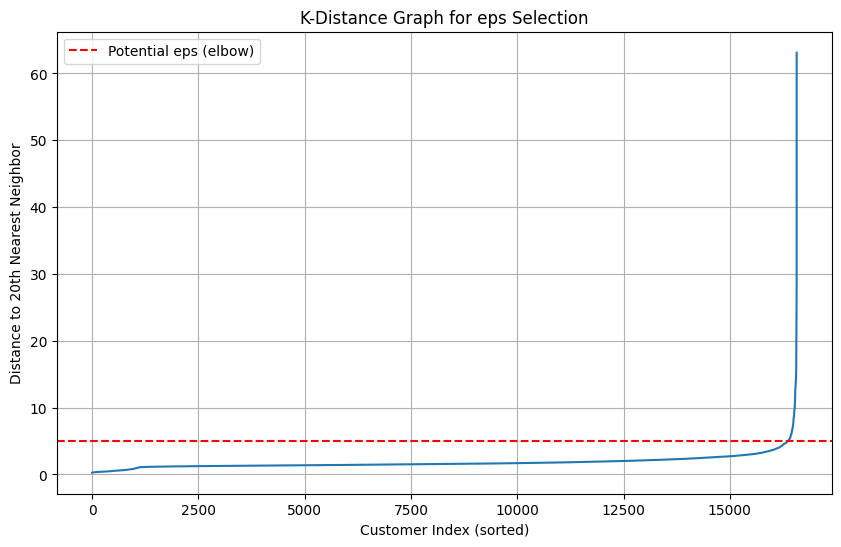

In [47]:
# Find optimal eps using K-distance method
nn_dbscan = NearestNeighbors(n_neighbors= 2 * len(metric_features)) # n_features * 2 as a rule of thumb
nn_dbscan.fit(df_outlier_treat[metric_features])
distances, _ = nn_dbscan.kneighbors(df_outlier_treat[metric_features]) # _ would be the indices of the n nearest neighbors, we only want the distances
# matrix of n_samples x n_neighbors nearest neighbors distances
distances = np.sort(distances[:, -1])
# distances will be a 1D array of the distance for every sample to the n nearest neighbor, sorted


plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("K-Distance Graph for eps Selection")
plt.xlabel("Customer Index (sorted)")
plt.ylabel("Distance to 20th Nearest Neighbor")
plt.grid(True)

plt.axhline(y=5, color='r', linestyle='--', label='Potential eps (elbow)') 
# NEED TO ADJUST THE VALUE OF EPS BASED ON THE GRAPH
# we choose the eps value at the elbow point

plt.legend()
plt.show()

In [48]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=2 * len(metric_features), n_jobs=-1)

dbscan_labels = dbscan.fit_predict(df_outlier_treat[metric_features])

In [49]:
# Print cluster counts for DBSCAN and get 
print(pd.Series(dbscan_labels).value_counts().sort_index())
r2_db = get_rsq(df_outlier_treat, metric_features, dbscan_labels)
print(f"DBSCAN R² score: {r2_db:.4f}")

-1       86
 0    16488
Name: count, dtype: int64
DBSCAN R² score: 0.0272


In [50]:
df_outlier_treat['DBSCAN_Labels'] = dbscan_labels
len(df_outlier_treat[df_outlier_treat['DBSCAN_Labels'] == -1]) / len(df_outlier_treat) * 100

0.5188850006033546

We already dropped 1.9% of the data when dealing with missing values and duplicates. We will now drop these outliers since the total percentage doesnt reach 5%.

In [51]:
df_outliers = df_outlier_treat[df_outlier_treat['DBSCAN_Labels'] == -1]
df_outlier_treat.drop((df_outlier_treat[df_outlier_treat['DBSCAN_Labels'] == -1].index), inplace=True)

####  2.6.2 Univariate outlier capping

Before clustering, we want to protect the algorithms from extreme values that are almost certainly data errors
But we don't want to lose real high-value customers and diversity in the data so we will apply capping using the 1st and 99th percentiles:

In [52]:
extreme = []
for col in metric_features:
    low  = df_outlier_treat[col].quantile(0.01)
    high = df_outlier_treat[col].quantile(0.99)
    n_low  = (df_outlier_treat[col] < low).sum()
    n_high = (df_outlier_treat[col] > high).sum()
    if n_low + n_high > 0:
        extreme.append([col, n_low, n_high])

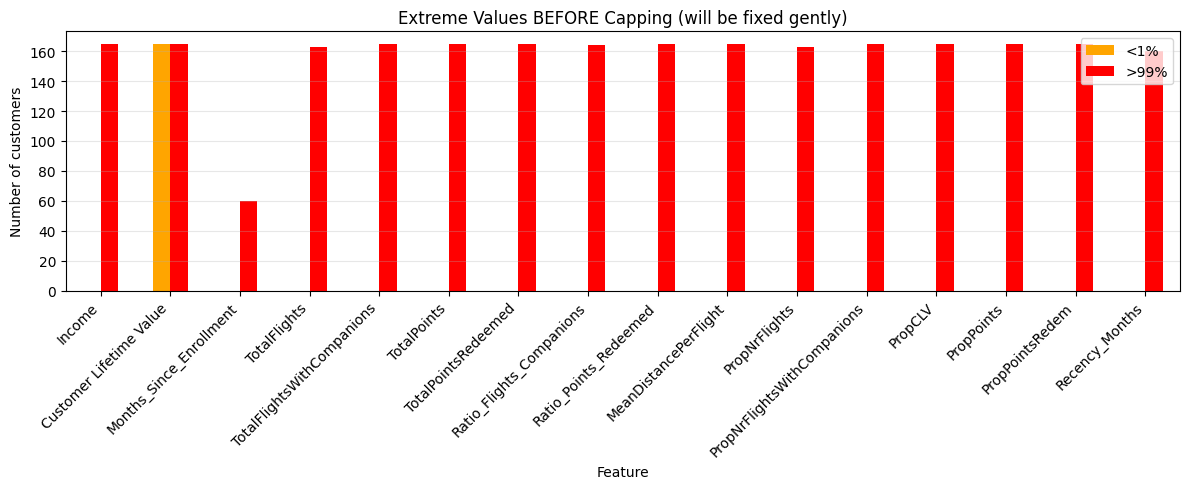

In [53]:
pd.DataFrame(extreme, columns=['Feature', '<1%', '>99%']).set_index('Feature').plot(
    kind='bar', figsize=(12,5), color=['orange','red'])
plt.title("Extreme Values BEFORE Capping (will be fixed gently)")
plt.ylabel("Number of customers")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

We can see from this visual that more than 160 customers have extreme values in several features 
These are the top 1% most extreme customers , some may be real vip customers but many values are so high that they can distort clustering algorithms.  
We will cap them at the 99th percentile (and also the few low values at the 1st percentile) so that our clustering remains stable and logic, while avoiding to remove other customers from the dataset.

In [54]:
print("Applying  capping ")

for col in metric_features:
    lower = df_outlier_treat[col].quantile(0.01)
    upper = df_outlier_treat[col].quantile(0.99)
    
    n_low  = (df_outlier_treat[col] < lower).sum()
    n_high = (df_outlier_treat[col] > upper).sum()
    
    df_outlier_treat[col] = df_outlier_treat[col].clip(lower=lower, upper=upper)
    
    if n_low + n_high > 0:
        print(f"{col:30} → capped {n_low:3} low | {n_high:3} high")

Applying  capping 
Income                         → capped   0 low | 165 high
Customer Lifetime Value        → capped 165 low | 165 high
Months_Since_Enrollment        → capped   0 low |  60 high
TotalFlights                   → capped   0 low | 163 high
TotalFlightsWithCompanions     → capped   0 low | 165 high
TotalPoints                    → capped   0 low | 165 high
TotalPointsRedeemed            → capped   0 low | 165 high
Ratio_Flights_Companions       → capped   0 low | 164 high
Ratio_Points_Redeemed          → capped   0 low | 165 high
MeanDistancePerFlight          → capped   0 low | 165 high
PropNrFlights                  → capped   0 low | 163 high
PropNrFlightsWithCompanions    → capped   0 low | 165 high
PropCLV                        → capped   0 low | 165 high
PropPoints                     → capped   0 low | 165 high
PropPointsRedem                → capped   0 low | 165 high
Recency_Months                 → capped   0 low | 160 high


### **2.7 Feature Selection**

In [55]:
df_clustering = df_outlier_treat.copy().drop(columns=['DBSCAN_Labels'])

Convert ChurnStatus into binary values (0/1) so it can be included in the clustering analysis.

In [56]:
df_clustering.columns

Index(['Income', 'Customer Lifetime Value', 'Months_In_Program',
       'Months_Since_Enrollment', 'TotalFlights', 'TotalFlightsWithCompanions',
       'TotalPoints', 'TotalPointsRedeemed', 'NumFlights_Max',
       'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions',
       'Ratio_Points_Redeemed', 'MeanDistancePerFlight', 'PropNrFlights',
       'PropNrFlightsWithCompanions', 'PropCLV', 'PropPoints',
       'PropPointsRedem', 'DiversitySeason', 'Recency_Months', 'First Name',
       'Last Name', 'Customer Name', 'Country', 'Province or State', 'City',
       'Postal code', 'Gender', 'Education', 'Location Code', 'Marital Status',
       'LoyaltyStatus', 'EnrollmentDateOpening', 'CancellationDate',
       'EnrollmentType', 'FirstFlightDate', 'MostFrequentSeason',
       'ChurnStatus', 'CLV_Category', 'Income_Category',
       'PropNrFlights_Category', 'Recency_Category'],
      dtype='object')

In [57]:
df_clustering['ChurnStatus'] = df_clustering['ChurnStatus'].map({'Active': 0, 'Cancelled': 1})

We'll drop cancelled clients and remove categorical features from df_clusterings, keeping only the numerical variables that are relevant for clustering.

In [58]:
#df_cancelled = df_clustering[df_clustering['ChurnStatus'] == 'Cancelled']
#df_clustering = df_clustering[df_clustering['ChurnStatus'] == 'Active']
df_clustering = df_clustering.select_dtypes(include=[np.number])

### **2.7.1 Correlation Matrix of Numeric Features**

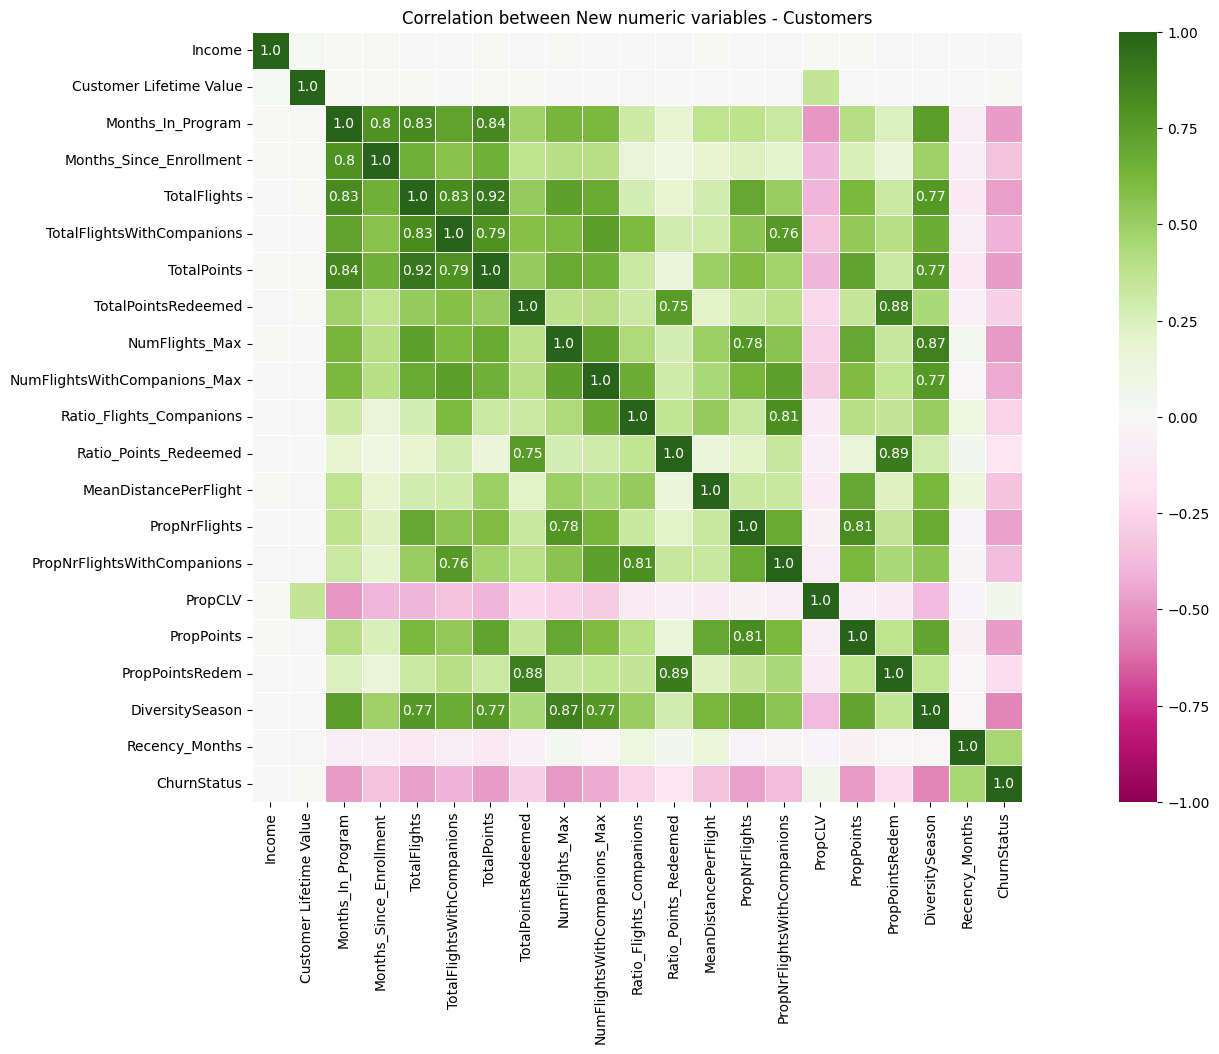

In [59]:
fig = plt.figure(figsize=(25, 10))


# # Plot heatmap of the correlation matrix
sns.heatmap(data=df_clustering.corr(), 
            annot=df_clustering.corr().round(2).astype(str).where(df_clustering.corr().abs() >= 0.75, ""), # Specify custom annotation
            fmt='s', # The annotation matrix now has strings, so we need to explicitly say this
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='PiYG' # Diverging color map
            )

plt.title("Correlation between New numeric variables - Customers")
plt.show()

features to drop:
months_in_program
total_flights

In [60]:
round(df_clustering.var(), 4)


Income                          0.9985
Customer Lifetime Value         0.8256
Months_In_Program               0.9867
Months_Since_Enrollment         0.9933
TotalFlights                    0.9825
TotalFlightsWithCompanions      0.9759
TotalPoints                     0.9853
TotalPointsRedeemed             0.9561
NumFlights_Max                  0.9877
NumFlightsWithCompanions_Max    0.9924
Ratio_Flights_Companions        0.8432
Ratio_Points_Redeemed           0.3417
MeanDistancePerFlight           0.4812
PropNrFlights                   0.9170
PropNrFlightsWithCompanions     0.8466
PropCLV                         0.3400
PropPoints                      0.9341
PropPointsRedem                 0.8983
DiversitySeason                 0.9871
Recency_Months                  0.8911
ChurnStatus                     0.1164
dtype: float64

In [61]:
df_clustering = df_clustering.copy().drop(['TotalFlights', 'Months_In_Program', 'Income'], axis=1)

income não tem correlações
total flights e total months, fazer análise de pares de variaveis para justificar

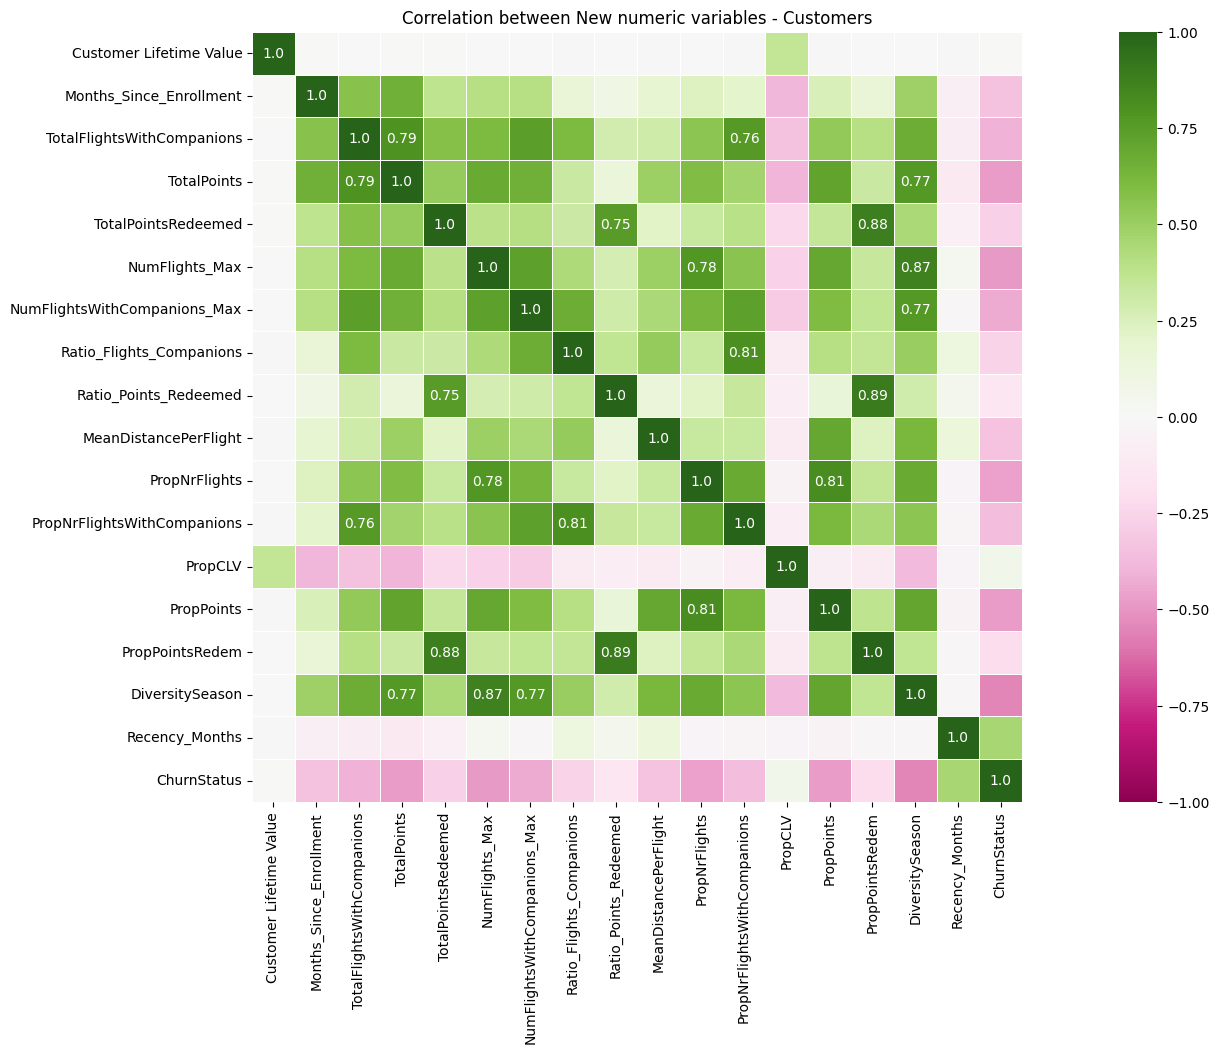

In [62]:
fig = plt.figure(figsize=(25, 10))


# # Plot heatmap of the correlation matrix
sns.heatmap(data=df_clustering.corr(), 
            annot=df_clustering.corr().round(2).astype(str).where(df_clustering.corr().abs() >= 0.75, ""), # Specify custom annotation
            fmt='s', # The annotation matrix now has strings, so we need to explicitly say this
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='PiYG' # Diverging color map
            )

plt.title("Correlation between New numeric variables - Customers")
plt.show()

In [63]:
from sklearn.cluster import KMeans
kmclust = KMeans(n_clusters=4, init='random', n_init=10, random_state=1)

In [64]:
R_squared = get_rsq(df_clustering, df_clustering.select_dtypes(include=[np.number]).columns.tolist(), kmclust.fit_predict(df_clustering.select_dtypes(include=[np.number])))
R_squared

np.float64(0.5266852392348917)

## **3. Clustering**

### **3.1 Multi perpective segmentation**

In [55]:
value_segmentation = ['Customer Lifetime Value', 'PropCLV', 'PropPointsRedem', 'TotalPointsRedeemed', 'TotalPoints', 'PropPoints']
behavioral_segmentation = ['Recency_Months', 'PropPointsRedem', 'TotalPointsRedeemed', 'TotalFlightsWithCompanions', 'NumFlights_Max', 'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed', 'MeanDistancePerFlight', 'PropNrFlights', 'PropNrFlightsWithCompanions', 'DiversitySeason', 'Months_Since_Enrollment']

demographic - não criar porque não temos. eram todas cat

vamos explorar fazer com e sem os cancelled. 

Com cancelled: os algoritmos podem conseguir identificar os clientes em risco mais facilmente


In [56]:
df_clustering.columns

Index(['Customer Lifetime Value', 'Months_Since_Enrollment',
       'TotalFlightsWithCompanions', 'TotalPoints', 'TotalPointsRedeemed',
       'NumFlights_Max', 'NumFlightsWithCompanions_Max',
       'Ratio_Flights_Companions', 'Ratio_Points_Redeemed',
       'MeanDistancePerFlight', 'PropNrFlights', 'PropNrFlightsWithCompanions',
       'PropCLV', 'PropPoints', 'PropPointsRedem', 'DiversitySeason',
       'Recency_Months', 'ChurnStatus'],
      dtype='object')

### **3.2 Hierarchical Clustering**

### **3.3 Kmeans**

### **3.3 Density Clustering**

#### **3.3.1 Mean Shift**

The first thing we will do is define the optimal bandwidth by exploring some values for the quantile 

Need to repete this for the different segments

In [57]:
# Estimate bandwidths for Mean Shift with different quantiles
bandwidth1 = estimate_bandwidth(df[segment1], quantile=0.03, random_state=1)
bandwidth2 = estimate_bandwidth(df[segment1], quantile = 0.06, random_state=1)
bandwidth3 = estimate_bandwidth(df[segment1], quantile=0.12, random_state=1)

NameError: name 'df' is not defined

In [ ]:
# Create Mean Shift models with different bandwidths
mst1 = MeanShift(bandwidth=bandwidth1, bin_seeding = True, n_jobs=4)
mst2 = MeanShift(bandwidth=bandwidth2, bin_seeding = True, n_jobs=4)
mst3 = MeanShift(bandwidth=bandwidth3, bin_seeding = True, n_jobs=4)

In [ ]:
# Fit Mean Shift models and predict cluster labels
ms_labels1 = mst1.fit_predict(df[segment1])
ms_labels2 = mst2.fit_predict(df[segment1])
ms_labels3 = mst3.fit_predict(df[segment])

In [ ]:
# Print cluster counts for each bandwidth
print(pd.Series(ms_labels1).value_counts().sort_index())
print(pd.Series(ms_labels2).value_counts().sort_index())
print(pd.Series(ms_labels3).value_counts().sort_index())

In [ ]:
# Finally get R² scores to evaluate clustering performance
r2_1 = get_rsq(df, segment1, ms_labels1)
print(f"R² score: {r2_1:.4f}")

r2_2 = get_rsq(df, segment1, ms_labels2)
print(f"R² score: {r2_2:.4f}")

r2_3 = get_rsq(df, segment1, ms_labels3)
print(f"R² score: {r2_3:.4f}")

#### **3.3.2 HDBSCAN**

#### **3.3.3 Gaussian Mixture Models (GMM)**

### **3.4 Self-Organizing Maps (SOM)**